In [10]:
import cv2
import dlib
import imutils
import numpy as np
import matplotlib.pyplot as plt
import _pickle as pkl
from keras.models import Sequential, load_model
from keras.layers import Dense
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imutils import face_utils

%matplotlib inline


In [11]:
x, y = pkl.load(open('./samples.pkl', 'rb'))

#print(x.shape, y.shape)

In [12]:
roll, pitch, yaw = y[:, 0], y[:, 1], y[:, 2]

#print(roll.min(), roll.max(), roll.mean(), roll.std())
#print(pitch.min(), pitch.max(), pitch.mean(), pitch.std())
#print(yaw.min(), yaw.max(), yaw.mean(), yaw.std())

In [13]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=0.5, random_state=42)

#print(x_train.shape, y_train.shape)
#print(x_val.shape, y_val.shape)
#print(x_test.shape, y_test.shape)

In [14]:
std = StandardScaler()
std.fit(x_train)
x_train = std.transform(x_train)
x_val = std.transform(x_val)
x_test = std.transform(x_test)

In [15]:
#Hyperparams
BATCH_SIZE = 64
EPOCHS = 100

In [16]:
# Training
model = Sequential()
model.add(Dense(units=20, activation='relu', kernel_regularizer='l2', input_dim=x.shape[1]))
model.add(Dense(units=10, activation='relu', kernel_regularizer='l2'))
model.add(Dense(units=3, activation='linear'))

#print(model.summary())

callback_list = [EarlyStopping(monitor='val_loss', patience=25)]

model.compile(optimizer='adam', loss='mean_squared_error')
hist = model.fit(x=x_train, y=y_train, validation_data=(x_val, y_val), batch_size=BATCH_SIZE, epochs=EPOCHS, callbacks=callback_list)
model.save('./model.h5')

print()
print('Train loss:', model.evaluate(x_train, y_train, verbose=0))
print('  Val loss:', model.evaluate(x_val, y_val, verbose=0))
print(' Test loss:', model.evaluate(x_test, y_test, verbose=0))

Train on 4401 samples, validate on 943 samples
Epoch 1/100
4401/4401 [==============================] - 2s 380us/step - loss: 65.0905 - val_loss: 54.7465
Epoch 2/100
4401/4401 [==============================] - 1s 147us/step - loss: 48.7363 - val_loss: 48.6921
Epoch 3/100
4401/4401 [==============================] - 0s 108us/step - loss: 43.3194 - val_loss: 40.2798
Epoch 4/100
4401/4401 [==============================] - 0s 107us/step - loss: 38.5571 - val_loss: 39.9275
Epoch 5/100
4401/4401 [==============================] - 0s 108us/step - loss: 36.6414 - val_loss: 40.0639
Epoch 6/100
4401/4401 [==============================] - 0s 104us/step - loss: 35.3326 - val_loss: 36.4179
Epoch 7/100
4401/4401 [==============================] - 1s 115us/step - loss: 36.0359 - val_loss: 39.5596
Epoch 8/100
4401/4401 [==============================] - 1s 116us/step - loss: 35.3884 - val_loss: 35.8301
Epoch 9/100
4401/4401 [==============================] - 1s 136us/step - loss: 34.3477 - val_loss

4401/4401 [==============================] - 0s 99us/step - loss: 29.6251 - val_loss: 33.0966
Epoch 77/100
4401/4401 [==============================] - 0s 103us/step - loss: 29.8764 - val_loss: 31.7054
Epoch 78/100
4401/4401 [==============================] - 0s 97us/step - loss: 29.1144 - val_loss: 34.0929
Epoch 79/100
4401/4401 [==============================] - 0s 102us/step - loss: 29.7630 - val_loss: 31.3395
Epoch 80/100
4401/4401 [==============================] - 0s 99us/step - loss: 29.1578 - val_loss: 33.7172
Epoch 81/100
4401/4401 [==============================] - 0s 102us/step - loss: 29.5882 - val_loss: 31.4421
Epoch 82/100
4401/4401 [==============================] - 0s 102us/step - loss: 30.1877 - val_loss: 34.1921
Epoch 83/100
4401/4401 [==============================] - 0s 98us/step - loss: 29.3919 - val_loss: 32.4718
Epoch 84/100
4401/4401 [==============================] - 0s 106us/step - loss: 29.3880 - val_loss: 32.1599
Epoch 85/100
4401/4401 [=====================

In [17]:
# Testing the model
def detect_face_points(image):
    detector = dlib.get_frontal_face_detector()
    predictor = dlib.shape_predictor("./shape_predictor_68_face_landmarks.dat")
    face_rect = detector(image, 1)
    if len(face_rect) != 1: return []
    
    dlib_points = predictor(image, face_rect[0])
    face_points = []
    for i in range(68):
        x, y = dlib_points.part(i).x, dlib_points.part(i).y
        face_points.append(np.array([x, y]))
    return face_points
        
def compute_features(face_points):
    assert (len(face_points) == 68), "len(face_points) must be 68"
    
    face_points = np.array(face_points)
    features = []
    for i in range(68):
        for j in range(i+1, 68):
            features.append(np.linalg.norm(face_points[i]-face_points[j]))
            
    return np.array(features).reshape(1, -1)

 Roll: -5.21°
Pitch: 4.26°
  Yaw: -19.63°


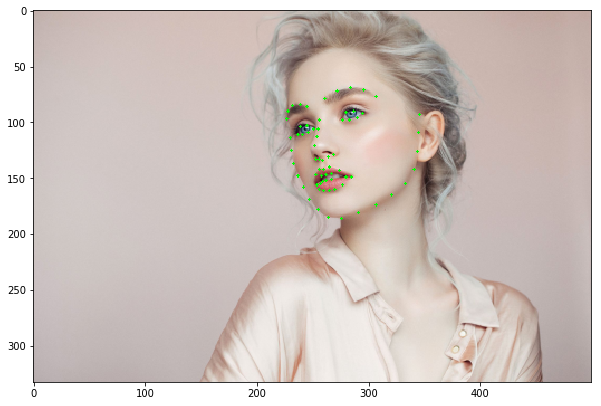

In [18]:
im = cv2.imread('C:\\Users\\David Abolude\\Documents\\GitHub\\Individual-Project\\Individual Project\\headPose.jpg', cv2.IMREAD_COLOR)
#im = cv2.VideoCapture(0)
im = imutils.resize(im, width=500)
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
face_points = detect_face_points(im)

for x, y in face_points:
    cv2.circle(im, (x, y), 1, (0, 255, 0), -1)
    
features = compute_features(face_points)
features = std.transform(features)

model = load_model('./model.h5')
y_pred = model.predict(features)

roll_pred, pitch_pred, yaw_pred = y_pred[0]
print(' Roll: {:.2f}°'.format(roll_pred))
print('Pitch: {:.2f}°'.format(pitch_pred))
print('  Yaw: {:.2f}°'.format(yaw_pred))
    
plt.figure(figsize=(10, 10))
plt.imshow(im)
#key = cv2.waitKey(1) & 0xFF
#if key == ord("q"): sys.exit()  # esc to quit
#cv2.destroyAllWindows()
